In [2]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [3]:
n = 32
x_1 = np.linspace(-np.pi, np.pi, 2*n+1)
x_2 = np.linspace(np.pi, -np.pi, 2*n+1)
x_3 = np.linspace(np.pi, -np.pi, 2*n+1)

X, Y, Z = np.meshgrid(x_1, x_2, x_3)

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [4]:
X_v_test = np.hstack((X.flatten(order='F')[:, None], Y.flatten(order='F')[:, None], Z.flatten(order='F')[:, None]))

vsol = (1-X**2/np.pi**2)**2*(1-Y**2/np.pi**2)**2*np.cos(Z)

r_1 = np.sqrt(X**2 + (Y+np.pi)**2)
theta_1 = np.arctan2(Y+np.pi, X)
theta_1 = np.where(theta_1 < 0, theta_1 + 2*np.pi, theta_1)
sd_1 = r_1**(1/2) * np.cos(theta_1/2)

r_2 = np.sqrt((X-np.pi)**2 + Y**2)
theta_2 = np.arctan2(np.pi-X, Y)
theta_2 = np.where(theta_2 < 0, theta_2 + 2*np.pi, theta_2)
sd_2 = r_2**(1/2) * np.sin(theta_2/2)

r_3 = np.sqrt(X**2 + (Y-np.pi)**2)
theta_3 = np.arctan2(np.pi-Y, -X)
theta_3 = np.where(theta_3 < 0, theta_3 + 2*np.pi, theta_3)
sd_3 = r_3**(1/2) * np.cos(theta_3/2)

r_4 = np.sqrt((X+np.pi)**2 + Y**2)
theta_4 = np.arctan2(X+np.pi, -Y)
theta_4 = np.where(theta_4 < 0, theta_4 + 2*np.pi, theta_4)
sd_4 = r_4**(1/2) * np.sin(theta_4/2)

R = 1/2
etad_1 = np.where(r_1 < R, 15 / 16 * (
                    8 / 15 - (4 * r_1 / R - 3) + 2 / 3 * (4 * r_1 / R - 3) ** 3 - 1 / 5 * (4 * r_1 / R - 3) ** 5), 0)
etad_1 = np.where(r_1 < R/2, 1, etad_1)

etad_2 = np.where(r_2 < R, 15 / 16 * (
                    8 / 15 - (4 * r_2 / R - 3) + 2 / 3 * (4 * r_2 / R - 3) ** 3 - 1 / 5 * (4 * r_2 / R - 3) ** 5), 0)
etad_2 = np.where(r_2 < R/2, 1, etad_2)

etad_3 = np.where(r_3 < R, 15 / 16 * (
                    8 / 15 - (4 * r_3 / R - 3) + 2 / 3 * (4 * r_3 / R - 3) ** 3 - 1 / 5 * (4 * r_3 / R - 3) ** 5), 0)
etad_3 = np.where(r_3 < R/2, 1, etad_3)

etad_4 = np.where(r_4 < R, 15 / 16 * (
                    8 / 15 - (4 * r_4 / R - 3) + 2 / 3 * (4 * r_4 / R - 3) ** 3 - 1 / 5 * (4 * r_4 / R - 3) ** 5), 0)
etad_4 = np.where(r_4 < R/2, 1, etad_4)

PHI_1 = r_1-np.log(2*np.cosh(r_1)-2*np.cos(Z))
PHI_2 = r_2-np.log(2*np.cosh(r_2)-2*np.cos(Z))
PHI_3 = r_3-np.log(2*np.cosh(r_3)-2*np.cos(Z))
PHI_4 = r_4-np.log(2*np.cosh(r_4)-2*np.cos(Z))
usol = vsol + sd_1 * etad_1 * PHI_1 + sd_2 * etad_2 * PHI_2 + sd_3 * etad_3 * PHI_3 + sd_4 * etad_4 * PHI_4

lb = np.array([-np.pi, -np.pi, -np.pi]) #lower bound
ub = np.array([np.pi, np.pi, np.pi])  #upper bound

v_true = vsol.flatten('F')[:, None]
u_true = usol.flatten('F')[:, None]

C:\Users\HP\AppData\Local\Temp/ipykernel_25240/546713074.py:42: RuntimeWarning: divide by zero encountered in log
  PHI_1 = r_1-np.log(2*np.cosh(r_1)-2*np.cos(Z))
C:\Users\HP\AppData\Local\Temp/ipykernel_25240/546713074.py:43: RuntimeWarning: divide by zero encountered in log
  PHI_2 = r_2-np.log(2*np.cosh(r_2)-2*np.cos(Z))
C:\Users\HP\AppData\Local\Temp/ipykernel_25240/546713074.py:44: RuntimeWarning: divide by zero encountered in log
  PHI_3 = r_3-np.log(2*np.cosh(r_3)-2*np.cos(Z))
C:\Users\HP\AppData\Local\Temp/ipykernel_25240/546713074.py:45: RuntimeWarning: divide by zero encountered in log
  PHI_4 = r_4-np.log(2*np.cosh(r_4)-2*np.cos(Z))
C:\Users\HP\AppData\Local\Temp/ipykernel_25240/546713074.py:46: RuntimeWarning: invalid value encountered in multiply
  usol = vsol + sd_1 * etad_1 * PHI_1 + sd_2 * etad_2 * PHI_2 + sd_3 * etad_3 * PHI_3 + sd_4 * etad_4 * PHI_4


# Training Data

In [5]:
def trainingdata(N_v,N_f,N_n):
    
    x = np.linspace(-np.pi,0,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    X, Z = np.meshgrid(x,z)
    edge1_x = np.hstack((X.flatten('F')[:,None], np.linspace(-np.pi,-np.pi,(2*n+1)*(n+1))[:,None], Z.flatten('F')[:,None]))
    edge1_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    x = np.linspace(0,np.pi,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    X, Z = np.meshgrid(x,z)
    edge2_x = np.hstack((X.flatten('F')[:,None], np.linspace(-np.pi,-np.pi,(2*n+1)*(n+1))[:,None], Z.flatten('F')[:,None]))
    edge2_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    y = np.linspace(-np.pi,0,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    Y, Z = np.meshgrid(y,z)
    edge3_x = np.hstack((np.linspace(np.pi,np.pi,(2*n+1)*(n+1))[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge3_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    y = np.linspace(0,np.pi,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    Y, Z = np.meshgrid(y,z)
    edge4_x = np.hstack((np.linspace(np.pi,np.pi,(2*n+1)*(n+1))[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge4_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    x = np.linspace(np.pi,0,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    X, Z = np.meshgrid(x,z)
    edge5_x = np.hstack((X.flatten('F')[:,None], np.linspace(np.pi,np.pi,(2*n+1)*(n+1))[:,None], Z.flatten('F')[:,None]))
    edge5_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    x = np.linspace(0,-np.pi,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    X, Z = np.meshgrid(x,z)
    edge6_x = np.hstack((X.flatten('F')[:,None], np.linspace(np.pi,np.pi,(2*n+1)*(n+1))[:,None], Z.flatten('F')[:,None]))
    edge6_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    y = np.linspace(np.pi,0,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    Y, Z = np.meshgrid(y,z)
    edge7_x = np.hstack((np.linspace(-np.pi,-np.pi,(2*n+1)*(n+1))[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge7_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    y = np.linspace(0,-np.pi,n+1)
    z = np.linspace(-np.pi,np.pi,2*n+1)
    Y, Z = np.meshgrid(y,z)
    edge8_x = np.hstack((np.linspace(-np.pi,-np.pi,(2*n+1)*(n+1))[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge8_v = np.linspace(0,0,(2*n+1)*(n+1))[:,None]
    
    x = np.linspace(-np.pi,np.pi,2*n+1)
    y = np.linspace(-np.pi,np.pi,2*n+1)
    X, Y = np.meshgrid(x,y)
    edge9_x = np.hstack((X.flatten('F')[:,None], Y.flatten('F')[:,None], np.linspace(-np.pi,-np.pi,(2*n+1)**2)[:,None]))
    edge9_v = np.linspace(0,0,(2*n+1)**2)[:,None]
    edge10_x = np.hstack((X.flatten('F')[:,None], Y.flatten('F')[:,None], np.linspace(np.pi,np.pi,(2*n+1)**2)[:,None]))
    edge10_v = np.linspace(0,0,(2*n+1)**2)[:,None]
    
    all_X_v_train = np.vstack([edge1_x, edge4_x, edge5_x, edge8_x])
    all_v_train = np.vstack([edge1_v, edge4_v, edge5_v, edge8_v])

    # choose random N_v points for Dirichlet training
    all_X_v_train_r = np.sqrt((all_X_v_train[:, 0]-np.pi)**2 + all_X_v_train[:, 1]**2)*np.sqrt((all_X_v_train[:, 0]+np.pi)**2 + all_X_v_train[:, 1]**2)*np.sqrt(all_X_v_train[:, 0]**2 + (all_X_v_train[:, 1]-np.pi)**2)*np.sqrt(all_X_v_train[:, 0]**2 + (all_X_v_train[:, 1]+np.pi)**2)
    probability = np.where(all_X_v_train_r < 1e-3, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False, p=probability)
    X_v_train = all_X_v_train[idx[0:N_v], :]  # choose indices from  set 'idx' (x,t)
    v_train = all_v_train[idx[0:N_v], :]
    
    neumann_xx = np.vstack([edge3_x,edge7_x])
    neumann_vx = np.vstack([edge3_v,edge7_v])
    neumann_xy = np.vstack([edge2_x,edge6_x])
    neumann_vy = np.vstack([edge2_v,edge6_v])
    neumann_xz = np.vstack([edge9_x,edge10_x])
    neumann_vz = np.vstack([edge9_v,edge10_v])
    
    N_n = N_n//4
    # choose random N_n points for Neumann training
    neumann_xx_r = np.sqrt((neumann_xx[:, 0]-np.pi)**2 + neumann_xx[:, 1]**2)*np.sqrt((neumann_xx[:, 0]+np.pi)**2 + neumann_xx[:, 1]**2)*np.sqrt(neumann_xx[:, 0]**2 + (neumann_xx[:, 1]-np.pi)**2)*np.sqrt(neumann_xx[:, 0]**2 + (neumann_xx[:, 1]+np.pi)**2)
    probability = np.where(neumann_xx_r < 1e-3, 0, 1)
    probability = probability / np.sum(probability)
    idx2 = np.random.choice(neumann_xx.shape[0], N_n, replace=False, p=probability)
    neumann_xx_train = neumann_xx[idx2[0:N_n], :]  # choose indices from  set 'idx' (x,t)
    neumann_vx_train = neumann_vx[idx2[0:N_n], :]
    neumann_xy_r = np.sqrt((neumann_xy[:, 0]-np.pi)**2 + neumann_xy[:, 1]**2)*np.sqrt((neumann_xy[:, 0]+np.pi)**2 + neumann_xy[:, 1]**2)*np.sqrt(neumann_xy[:, 0]**2 + (neumann_xy[:, 1]-np.pi)**2)*np.sqrt(neumann_xy[:, 0]**2 + (neumann_xy[:, 1]+np.pi)**2)
    probability = np.where(neumann_xy_r < 1e-3, 0, 1)
    probability = probability / np.sum(probability)
    idx2 = np.random.choice(neumann_xy.shape[0], N_n, replace=False, p=probability)
    neumann_xy_train = neumann_xy[idx2[0:N_n], :]  # choose indices from  set 'idx' (x,t)
    neumann_vy_train = neumann_vy[idx2[0:N_n], :]
    neumann_xz_r = np.sqrt((neumann_xz[:, 0]-np.pi)**2 + neumann_xz[:, 1]**2)*np.sqrt((neumann_xz[:, 0]+np.pi)**2 + neumann_xz[:, 1]**2)*np.sqrt(neumann_xz[:, 0]**2 + (neumann_xz[:, 1]-np.pi)**2)*np.sqrt(neumann_xz[:, 0]**2 + (neumann_xz[:, 1]+np.pi)**2)
    probability = np.where(neumann_xz_r < 1e-3, 0, 1)
    probability = probability / np.sum(probability)
    idx2 = np.random.choice(neumann_xz.shape[0], 2*N_n, replace=False, p=probability)
    neumann_xz_train = neumann_xz[idx2[0:2*N_n], :]  # choose indices from  set 'idx' (x,t)
    neumann_vz_train = neumann_vz[idx2[0:2*N_n], :]
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    X_v_test_r = np.sqrt((X_v_test[:, 0]-np.pi)**2 + X_v_test[:, 1]**2)*np.sqrt((X_v_test[:, 0]+np.pi)**2 + X_v_test[:, 1]**2)*np.sqrt(X_v_test[:, 0]**2 + (X_v_test[:, 1]-np.pi)**2)*np.sqrt(X_v_test[:, 0]**2 + (X_v_test[:, 1]+np.pi)**2)*np.sqrt(X_v_test[:, 0]**2 + X_v_test[:, 1]**2)
    probability = np.where(X_v_test_r < 1e-3, 0, 1)
    probability = probability / np.sum(probability)
    
    idx = np.random.choice(X_v_test.shape[0], N_f, replace=False, p=probability)
    X_f = X_v_test[idx[0:N_f], :]

    X_f_train = np.vstack((X_f, X_v_train, neumann_xx_train, neumann_xy_train, neumann_xz_train))  # append training points to collocation points

    return X_f_train, X_v_train, v_train, neumann_xx_train, neumann_xy_train, neumann_xz_train

# SEPINN - cutoff

Creating sequential layers using the class
tf.Module

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.lambdah_1 = torch.autograd.Variable(torch.ones(16).to(device),requires_grad=True)
        self.lambdah_2 = torch.autograd.Variable(torch.ones(16).to(device),requires_grad=True)
        self.lambdah_3 = torch.autograd.Variable(torch.ones(16).to(device),requires_grad=True)
        self.lambdah_4 = torch.autograd.Variable(torch.ones(16).to(device),requires_grad=True)
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
        
        loss_v = self.loss_function(self.forward(x), y)
                
        return loss_v
    
    def loss_neumann(self, neumann_xx, neumann_xy, neumann_xz):
                
        g = neumann_xx.clone()               
        g.requires_grad = True
        vv = self.forward(g)       
        v_x = autograd.grad(vv,g,torch.ones([neumann_xx.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_1 = v_x[:,[0]]
        
        g = neumann_xy.clone()               
        g.requires_grad = True
        vv = self.forward(g)       
        v_x = autograd.grad(vv,g,torch.ones([neumann_xy.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_2 = v_x[:,[1]]
        
        g = neumann_xz.clone()               
        g.requires_grad = True
        vv = self.forward(g)       
        v_x = autograd.grad(vv,g,torch.ones([neumann_xz.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_3 = v_x[:,[2]]
        
        v_n = torch.vstack((v_x_1,v_x_2,v_x_3))
        neumann_v = torch.zeros([v_n.shape[0], 1]).to(device)
        
        loss_neumann = self.loss_function(v_n, neumann_v)
                
        return loss_neumann
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
        x_3_f = x_to_train_f[:,[2]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv = self.forward(g)
                
        v_x = autograd.grad(vv,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]        
        v_xx = autograd.grad(v_x[:,[0]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy = autograd.grad(v_x[:,[1]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_zz = autograd.grad(v_x[:,[2]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        v_xx_1 = v_xx[:,[0]]
        v_xx_2 = v_yy[:,[1]]
        v_xx_3 = v_zz[:,[2]]
                        
        z = x_3_f
        
        r_1 = torch.sqrt(x_1_f ** 2 + (x_2_f+np.pi) ** 2)
        theta_1 = np.arctan2(x_2_f+np.pi, x_1_f)
        theta_1 = torch.where(theta_1 < 0, theta_1 + 2 * np.pi, theta_1)
        
        deltap_1 = torch.where(r_1 < R, -(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/(4*r_1**1.5) - 2*r_1**0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_1)) + 4*r_1**0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.sin(z)**2*np.cos(theta_1/2)/(-2*np.cos(z) + 2*np.cosh(r_1))**2 + (0.5*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/r_1**0.5 + r_1**0.5*(1 - 2*np.sinh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2) + r_1**0.5*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2) + r_1*(-0.25*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/r_1**1.5 + 1.0*(1 - 2*np.sinh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/r_1**0.5 + 1.0*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2)/r_1**0.5 + 2*r_1**0.5*(1 - 2*np.sinh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)))*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2) + r_1**0.5*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*(1920.0*r_1 - 240.0*(8*r_1 - 3)**3 - 720.0)*np.cos(theta_1/2) + r_1**0.5*(-2*np.cosh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)) + 4*np.sinh(r_1)**2/(-2*np.cos(z) + 2*np.cosh(r_1))**2)*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)))/r_1, 0)
        deltap_1 = torch.where(r_1 < R / 2, -(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*np.cos(theta_1/2)/(4*r_1**1.5) - 2*r_1**0.5*np.cos(theta_1/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_1)) + 4*r_1**0.5*np.sin(z)**2*np.cos(theta_1/2)/(-2*np.cos(z) + 2*np.cosh(r_1))**2 + (0.5*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*np.cos(theta_1/2)/r_1**0.5 + r_1**0.5*(1 - 2*np.sinh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)))*np.cos(theta_1/2) + r_1*(-0.25*(r_1 - np.log(-2*np.cos(z) + 2*np.cosh(r_1)))*np.cos(theta_1/2)/r_1**1.5 + 1.0*(1 - 2*np.sinh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)))*np.cos(theta_1/2)/r_1**0.5 + r_1**0.5*(-2*np.cosh(r_1)/(-2*np.cos(z) + 2*np.cosh(r_1)) + 4*np.sinh(r_1)**2/(-2*np.cos(z) + 2*np.cosh(r_1))**2)*np.cos(theta_1/2)))/r_1, deltap_1)
        
        r_2 = torch.sqrt((x_1_f-np.pi) ** 2 + x_2_f ** 2)
        theta_2 = np.arctan2(np.pi-x_1_f, x_2_f)
        theta_2 = torch.where(theta_2 < 0, theta_2 + 2 * np.pi, theta_2)
        
        deltap_2 = torch.where(r_2 < R, -(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/(4*r_2**1.5) - 2*r_2**0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_2)) + 4*r_2**0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.sin(z)**2/(-2*np.cos(z) + 2*np.cosh(r_2))**2 + (0.5*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/r_2**0.5 + r_2**0.5*(1 - 2*np.sinh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2) + r_2**0.5*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2) + r_2*(-0.25*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/r_2**1.5 + 1.0*(1 - 2*np.sinh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/r_2**0.5 + 1.0*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2)/r_2**0.5 + 2*r_2**0.5*(1 - 2*np.sinh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)))*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2) + r_2**0.5*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*(1920.0*r_2 - 240.0*(8*r_2 - 3)**3 - 720.0)*np.sin(theta_2/2) + r_2**0.5*(-2*np.cosh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)) + 4*np.sinh(r_2)**2/(-2*np.cos(z) + 2*np.cosh(r_2))**2)*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)))/r_2, 0)
        deltap_2 = torch.where(r_2 < R / 2, -(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*np.sin(theta_2/2)/(4*r_2**1.5) - 2*r_2**0.5*np.sin(theta_2/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_2)) + 4*r_2**0.5*np.sin(theta_2/2)*np.sin(z)**2/(-2*np.cos(z) + 2*np.cosh(r_2))**2 + (0.5*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*np.sin(theta_2/2)/r_2**0.5 + r_2**0.5*(1 - 2*np.sinh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)))*np.sin(theta_2/2) + r_2*(-0.25*(r_2 - np.log(-2*np.cos(z) + 2*np.cosh(r_2)))*np.sin(theta_2/2)/r_2**1.5 + 1.0*(1 - 2*np.sinh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)))*np.sin(theta_2/2)/r_2**0.5 + r_2**0.5*(-2*np.cosh(r_2)/(-2*np.cos(z) + 2*np.cosh(r_2)) + 4*np.sinh(r_2)**2/(-2*np.cos(z) + 2*np.cosh(r_2))**2)*np.sin(theta_2/2)))/r_2, deltap_2)
        
        r_3 = torch.sqrt(x_1_f ** 2 + (x_2_f-np.pi) ** 2)
        theta_3 = np.arctan2(np.pi-x_2_f, -x_1_f)
        theta_3 = torch.where(theta_3 < 0, theta_3 + 2 * np.pi, theta_3)
        
        deltap_3 = torch.where(r_3 < R, -(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/(4*r_3**1.5) - 2*r_3**0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_3)) + 4*r_3**0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.sin(z)**2*np.cos(theta_3/2)/(-2*np.cos(z) + 2*np.cosh(r_3))**2 + (0.5*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/r_3**0.5 + r_3**0.5*(1 - 2*np.sinh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2) + r_3**0.5*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2) + r_3*(-0.25*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/r_3**1.5 + 1.0*(1 - 2*np.sinh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/r_3**0.5 + 1.0*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2)/r_3**0.5 + 2*r_3**0.5*(1 - 2*np.sinh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)))*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2) + r_3**0.5*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*(1920.0*r_3 - 240.0*(8*r_3 - 3)**3 - 720.0)*np.cos(theta_3/2) + r_3**0.5*(-2*np.cosh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)) + 4*np.sinh(r_3)**2/(-2*np.cos(z) + 2*np.cosh(r_3))**2)*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)))/r_3, 0)
        deltap_3 = torch.where(r_3 < R / 2, -(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*np.cos(theta_3/2)/(4*r_3**1.5) - 2*r_3**0.5*np.cos(theta_3/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_3)) + 4*r_3**0.5*np.sin(z)**2*np.cos(theta_3/2)/(-2*np.cos(z) + 2*np.cosh(r_3))**2 + (0.5*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*np.cos(theta_3/2)/r_3**0.5 + r_3**0.5*(1 - 2*np.sinh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)))*np.cos(theta_3/2) + r_3*(-0.25*(r_3 - np.log(-2*np.cos(z) + 2*np.cosh(r_3)))*np.cos(theta_3/2)/r_3**1.5 + 1.0*(1 - 2*np.sinh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)))*np.cos(theta_3/2)/r_3**0.5 + r_3**0.5*(-2*np.cosh(r_3)/(-2*np.cos(z) + 2*np.cosh(r_3)) + 4*np.sinh(r_3)**2/(-2*np.cos(z) + 2*np.cosh(r_3))**2)*np.cos(theta_3/2)))/r_3, deltap_3)
        
        r_4 = torch.sqrt((x_1_f+np.pi) ** 2 + x_2_f ** 2)
        theta_4 = np.arctan2(x_1_f+np.pi, -x_2_f)
        theta_4 = torch.where(theta_4 < 0, theta_4 + 2 * np.pi, theta_4)
        
        deltap_4 = torch.where(r_4 < R, -(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/(4*r_4**1.5) - 2*r_4**0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_4)) + 4*r_4**0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.sin(z)**2/(-2*np.cos(z) + 2*np.cosh(r_4))**2 + (0.5*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/r_4**0.5 + r_4**0.5*(1 - 2*np.sinh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2) + r_4**0.5*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2) + r_4*(-0.25*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/r_4**1.5 + 1.0*(1 - 2*np.sinh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/r_4**0.5 + 1.0*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2)/r_4**0.5 + 2*r_4**0.5*(1 - 2*np.sinh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)))*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2) + r_4**0.5*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*(1920.0*r_4 - 240.0*(8*r_4 - 3)**3 - 720.0)*np.sin(theta_4/2) + r_4**0.5*(-2*np.cosh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)) + 4*np.sinh(r_4)**2/(-2*np.cos(z) + 2*np.cosh(r_4))**2)*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)))/r_4, 0)
        deltap_4 = torch.where(r_4 < R / 2, -(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*np.sin(theta_4/2)/(4*r_4**1.5) - 2*r_4**0.5*np.sin(theta_4/2)*np.cos(z)/(-2*np.cos(z) + 2*np.cosh(r_4)) + 4*r_4**0.5*np.sin(theta_4/2)*np.sin(z)**2/(-2*np.cos(z) + 2*np.cosh(r_4))**2 + (0.5*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*np.sin(theta_4/2)/r_4**0.5 + r_4**0.5*(1 - 2*np.sinh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)))*np.sin(theta_4/2) + r_4*(-0.25*(r_4 - np.log(-2*np.cos(z) + 2*np.cosh(r_4)))*np.sin(theta_4/2)/r_4**1.5 + 1.0*(1 - 2*np.sinh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)))*np.sin(theta_4/2)/r_4**0.5 + r_4**0.5*(-2*np.cosh(r_4)/(-2*np.cos(z) + 2*np.cosh(r_4)) + 4*np.sinh(r_4)**2/(-2*np.cos(z) + 2*np.cosh(r_4))**2)*np.sin(theta_4/2)))/r_4, deltap_4)
        
        f = ((4*np.pi**2 - 12* x_1_f**2)*(np.pi**2 - x_2_f**2)**2 + (4*np.pi**2 - 12* x_2_f**2)*(np.pi**2 - x_1_f**2)**2 + (np.pi**2 - x_1_f**2)**2*(np.pi**2 - x_2_f**2)**2)/np.pi**8*np.cos(z)-deltap_1-deltap_2-deltap_3-deltap_4
        
        deltap0_1 = torch.where(r_1 < R, -(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/(4*r_1**1.5) + (0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/r_1**0.5 + r_1**0.5*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2) + r_1*(-0.25*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)/r_1**1.5 + 1.0*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2)/r_1**0.5 + r_1**0.5*(1920.0*r_1 - 240.0*(8*r_1 - 3)**3 - 720.0)*np.cos(theta_1/2)))/r_1, 0)
        deltap0_1 = torch.where(r_1 < R / 2, 0, deltap0_1)
        deltaphat_1 = self.lambdah_1[0] * deltap0_1
        for n in range(1,16):
            phat = torch.where(r_1 < R, (r_1*(1.0*n**2*r_1**0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) - 1.0*n*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**0.5) - 2.0*n*r_1**0.5*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) - 0.25*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**1.5) + 1.0*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**0.5) + r_1**0.5*(1920.0*r_1 - 240.0*(8*r_1 - 3)**3 - 720.0)*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1)) - 1.0*n*r_1**0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) + 0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**0.5) + r_1**0.5*(-7.5*(8*r_1 - 3)**4 + 15.0*(8*r_1 - 3)**2 - 7.5)*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1))/r_1 - n**2*r_1**0.5*(-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) - (-7.5*r_1 - 0.1875*(8*r_1 - 3)**5 + 0.625*(8*r_1 - 3)**3 + 3.3125)*np.cos(theta_1/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_1)*r_1**1.5), 0)
            phat = torch.where(r_1 < R / 2, (r_1*(1.0*n**2*r_1**0.5*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) - 1.0*n*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**0.5) - 0.25*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**1.5)) - 1.0*n*r_1**0.5*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) + 0.5*np.cos(theta_1/2)*np.cos(n*z)/(2.71828182845905**(n*r_1)*r_1**0.5))/r_1 - n**2*r_1**0.5*np.cos(theta_1/2)*np.cos(n*z)/2.71828182845905**(n*r_1) - np.cos(theta_1/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_1)*r_1**1.5), phat)
            deltaphat_1 = deltaphat_1 + self.lambdah_1[n]*phat
        
        deltap0_2 = torch.where(r_2 < R, -(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/(4*r_2**1.5) + (0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/r_2**0.5 + r_2**0.5*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2) + r_2*(-0.25*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)/r_2**1.5 + 1.0*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2)/r_2**0.5 + r_2**0.5*(1920.0*r_2 - 240.0*(8*r_2 - 3)**3 - 720.0)*np.sin(theta_2/2)))/r_2, 0)
        deltap0_2 = torch.where(r_2 < R / 2, 0, deltap0_2)
        deltaphat_2 = self.lambdah_2[0] * deltap0_2
        for n in range(1,16):
            phat = torch.where(r_2 < R, (r_2*(1.0*n**2*r_2**0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) - 1.0*n*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**0.5) - 2.0*n*r_2**0.5*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) - 0.25*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**1.5) + 1.0*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**0.5) + r_2**0.5*(1920.0*r_2 - 240.0*(8*r_2 - 3)**3 - 720.0)*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2)) - 1.0*n*r_2**0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) + 0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**0.5) + r_2**0.5*(-7.5*(8*r_2 - 3)**4 + 15.0*(8*r_2 - 3)**2 - 7.5)*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2))/r_2 - n**2*r_2**0.5*(-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) - (-7.5*r_2 - 0.1875*(8*r_2 - 3)**5 + 0.625*(8*r_2 - 3)**3 + 3.3125)*np.sin(theta_2/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_2)*r_2**1.5), 0)
            phat = torch.where(r_2 < R / 2, (r_2*(1.0*n**2*r_2**0.5*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) - 1.0*n*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**0.5) - 0.25*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**1.5)) - 1.0*n*r_2**0.5*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) + 0.5*np.sin(theta_2/2)*np.cos(n*z)/(2.71828182845905**(n*r_2)*r_2**0.5))/r_2 - n**2*r_2**0.5*np.sin(theta_2/2)*np.cos(n*z)/2.71828182845905**(n*r_2) - np.sin(theta_2/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_2)*r_2**1.5), phat)
            deltaphat_2 = deltaphat_2 + self.lambdah_2[n]*phat
        
        deltap0_3 = torch.where(r_3 < R, -(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/(4*r_3**1.5) + (0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/r_3**0.5 + r_3**0.5*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2) + r_3*(-0.25*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)/r_3**1.5 + 1.0*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2)/r_3**0.5 + r_3**0.5*(1920.0*r_3 - 240.0*(8*r_3 - 3)**3 - 720.0)*np.cos(theta_3/2)))/r_3, 0)
        deltap0_3 = torch.where(r_3 < R / 2, 0, deltap0_3)
        deltaphat_3 = self.lambdah_3[0] * deltap0_3
        for n in range(1,16):
            phat = torch.where(r_3 < R, (r_3*(1.0*n**2*r_3**0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) - 1.0*n*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**0.5) - 2.0*n*r_3**0.5*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) - 0.25*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**1.5) + 1.0*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**0.5) + r_3**0.5*(1920.0*r_3 - 240.0*(8*r_3 - 3)**3 - 720.0)*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3)) - 1.0*n*r_3**0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) + 0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**0.5) + r_3**0.5*(-7.5*(8*r_3 - 3)**4 + 15.0*(8*r_3 - 3)**2 - 7.5)*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3))/r_3 - n**2*r_3**0.5*(-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) - (-7.5*r_3 - 0.1875*(8*r_3 - 3)**5 + 0.625*(8*r_3 - 3)**3 + 3.3125)*np.cos(theta_3/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_3)*r_3**1.5), 0)
            phat = torch.where(r_3 < R / 2, (r_3*(1.0*n**2*r_3**0.5*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) - 1.0*n*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**0.5) - 0.25*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**1.5)) - 1.0*n*r_3**0.5*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) + 0.5*np.cos(theta_3/2)*np.cos(n*z)/(2.71828182845905**(n*r_3)*r_3**0.5))/r_3 - n**2*r_3**0.5*np.cos(theta_3/2)*np.cos(n*z)/2.71828182845905**(n*r_3) - np.cos(theta_3/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_3)*r_3**1.5), phat)
            deltaphat_3 = deltaphat_3 + self.lambdah_3[n]*phat

        deltap0_4 = torch.where(r_4 < R, -(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/(4*r_4**1.5) + (0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/r_4**0.5 + r_4**0.5*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2) + r_4*(-0.25*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)/r_4**1.5 + 1.0*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2)/r_4**0.5 + r_4**0.5*(1920.0*r_4 - 240.0*(8*r_4 - 3)**3 - 720.0)*np.sin(theta_4/2)))/r_4, 0)
        deltap0_4 = torch.where(r_4 < R / 2, 0, deltap0_4)
        deltaphat_4 = self.lambdah_4[0] * deltap0_4
        for n in range(1,16):
            phat = torch.where(r_4 < R, (r_4*(1.0*n**2*r_4**0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) - 1.0*n*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**0.5) - 2.0*n*r_4**0.5*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) - 0.25*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**1.5) + 1.0*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**0.5) + r_4**0.5*(1920.0*r_4 - 240.0*(8*r_4 - 3)**3 - 720.0)*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4)) - 1.0*n*r_4**0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) + 0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**0.5) + r_4**0.5*(-7.5*(8*r_4 - 3)**4 + 15.0*(8*r_4 - 3)**2 - 7.5)*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4))/r_4 - n**2*r_4**0.5*(-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) - (-7.5*r_4 - 0.1875*(8*r_4 - 3)**5 + 0.625*(8*r_4 - 3)**3 + 3.3125)*np.sin(theta_4/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_4)*r_4**1.5), 0)
            phat = torch.where(r_4 < R / 2, (r_4*(1.0*n**2*r_4**0.5*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) - 1.0*n*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**0.5) - 0.25*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**1.5)) - 1.0*n*r_4**0.5*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) + 0.5*np.sin(theta_4/2)*np.cos(n*z)/(2.71828182845905**(n*r_4)*r_4**0.5))/r_4 - n**2*r_4**0.5*np.sin(theta_4/2)*np.cos(n*z)/2.71828182845905**(n*r_4) - np.sin(theta_4/2)*np.cos(n*z)/(4*2.71828182845905**(n*r_4)*r_4**1.5), phat)
            deltaphat_4 = deltaphat_4 + self.lambdah_4[n]*phat
        
        F = v_xx_1 + v_xx_2 + v_xx_3 + f + deltaphat_1 + deltaphat_2 + deltaphat_3 + deltaphat_4
        
        loss_f = self.loss_function(F, f_hat)
        
        return loss_f
    
    def loss(self,x,y,x_to_train_f,neumann_xx, neumann_xy, neumann_xz,sigma):

        loss_v = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        loss_n = self.loss_neumann(neumann_xx, neumann_xy, neumann_xz)

        loss = 100 * loss_n + sigma * loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train, neumann_xx, neumann_xy, neumann_xz, sigma)
        
        #error_vec, _ = PINN.test()
        
        #print(loss_val,error_vec)
        
        global ite
        ite = ite + 1
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((v-v_pred),2)/torch.linalg.norm(v,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = np.reshape(v_pred.cpu().detach().numpy(),(65,65,65),order='F') 
        
        u_pred = u_pred + self.lambdah_1[0].cpu().detach().numpy() * sd_1 * etad_1
        for n in range(1,16):
            PHInd = math.e**(-n*r_1)*np.cos(n*Z)
            u_pred = u_pred + self.lambdah_1[n].cpu().detach().numpy() * sd_1 * etad_1 * PHInd
        
        u_pred = u_pred + self.lambdah_2[0].cpu().detach().numpy() * sd_2 * etad_2
        for n in range(1,16):
            PHInd = math.e**(-n*r_2)*np.cos(n*Z)
            u_pred = u_pred + self.lambdah_2[n].cpu().detach().numpy() * sd_2 * etad_2 * PHInd
        
        u_pred = u_pred + self.lambdah_3[0].cpu().detach().numpy() * sd_3 * etad_3
        for n in range(1,16):
            PHInd = math.e**(-n*r_3)*np.cos(n*Z)
            u_pred = u_pred + self.lambdah_3[n].cpu().detach().numpy() * sd_3 * etad_3 * PHInd
        
        u_pred = u_pred + self.lambdah_4[0].cpu().detach().numpy() * sd_4 * etad_4
        for n in range(1,16):
            PHInd = math.e**(-n*r_4)*np.cos(n*Z)
            u_pred = u_pred + self.lambdah_4[n].cpu().detach().numpy() * sd_4 * etad_4 * PHInd
         
        print('lambdah1:',self.lambdah_1)
        print('lambdah2:',self.lambdah_2)
        print('lambdah3:',self.lambdah_3)
        print('lambdah4:',self.lambdah_4)
        
        return error_vec, u_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)
lambdah1: tensor([ 2.4763e-04,  1.9985e+00,  1.0087e+00,  6.7281e-01,  5.1538e-01,
         4.0184e-01,  3.1959e-01,  2.5984e-01,  1.8298e-01,  1.3174e-01,
         4.9766e-02,  1.7544e-03, -6.0320e-02, -8.6117e-02, -5.5869e-02,
        -6.2956e-02], requires_grad=True)
lambdah2: tensor([2.9810e-04, 1.9932e+00, 1.0020e+00, 6.6629e-01, 4.8951e-01, 3.9272e-01,
        3.1089e-01, 2.7772e-01, 2.3612e-01, 1.6849e-01, 1.3174e-01, 1.4534e-01,
        1.3719e-01, 1.0665e-01, 1.1616e-01, 6.1959e-02], requires_grad=True)
lambdah3: tensor([1.1018e-03, 1.9902e+00, 9.9630e-01, 6.5206e-01, 4.8902e-01, 3.9834e-01,
        3.2622e-01, 2.3514e-01, 2.1324e-01, 3.0520e-01

C:\Users\HP\AppData\Local\Temp/ipykernel_25240/1942157605.py:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, usol[:,:,0], cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_25240/1942157605.py:93: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, u_pred[:,:,0], cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_25240/1942157605.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensio

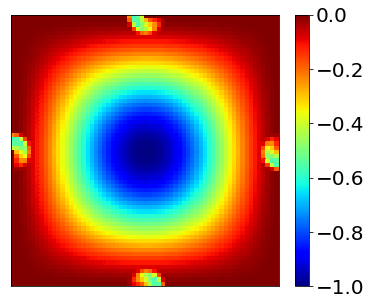

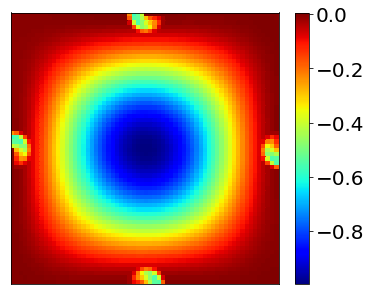

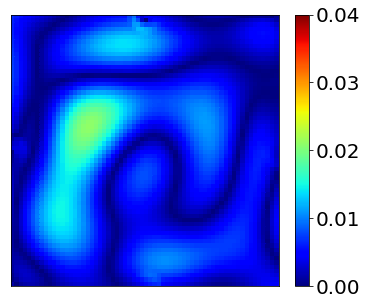

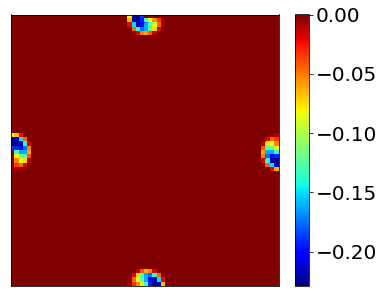

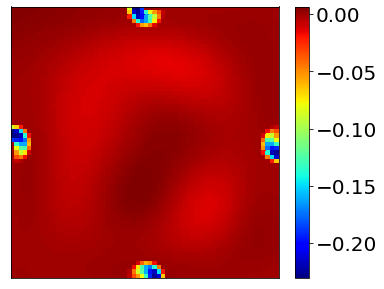

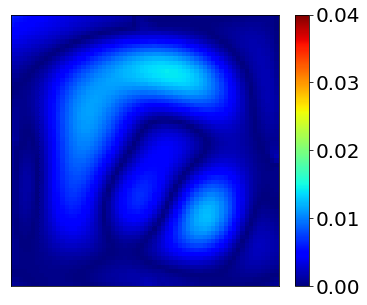

In [7]:
N_v = 800
N_n = 1200
N_f = 10000

X_f_train_np_array, X_v_train_np_array, v_train_np_array, neumann_xx_train_np_array, neumann_xy_train_np_array, neumann_xz_train_np_array = trainingdata(N_v,N_f,N_n)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
#v_train = torch.zeros(X_v_train.shape[0],1).to(device)
v_train = torch.from_numpy(v_train_np_array).float().to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
neumann_xx = torch.from_numpy(neumann_xx_train_np_array).float().to(device)
neumann_xy = torch.from_numpy(neumann_xy_train_np_array).float().to(device)
neumann_xz = torch.from_numpy(neumann_xz_train_np_array).float().to(device)

layers = np.array([3,10,10,10,1])

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)
params = list(PINN.parameters())

sigma = 100

start_time = time.time()
error_vec = 1

optimizer = optim.Adam(PINN.parameters(), lr=2e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizerl = optim.Adam([PINN.lambdah_1], lr=11e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer2 = optim.Adam([PINN.lambdah_2], lr=7e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer3 = optim.Adam([PINN.lambdah_3], lr=11e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer4 = optim.Adam([PINN.lambdah_4], lr=7e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
max_iter = 1000
for i in range(max_iter):
    loss = PINN.loss(X_v_train, v_train, X_f_train, neumann_xx, neumann_xy, neumann_xz, sigma)
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizerl.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer2.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer3.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer4.zero_grad()     # zeroes the gradient buffers of all parameters
    loss.backward()       #backprop
    optimizer.step()
    optimizerl.step()
    optimizer2.step()
    optimizer3.step()
    optimizer4.step()

ite = 1000
while sigma<1000 and error_vec>0.01:
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1,
                              max_iter = 2500, 
                              max_eval = None, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer.step(PINN.closure)
    sigma = 1.5 * sigma
    error_vec, _ = PINN.test()
    print(error_vec)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('sigma: %f' %(sigma/1.5))
print('Test Error: %.5f'  % (error_vec))
print('iteration: %d' %(ite))

# Plotting
fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(x_1, x_2, usol[:,:,0], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true-4-pi',bbox_inches='tight')

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(x_1, x_2, u_pred[:,:,0], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred-4-pi',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(x_1, x_2, np.abs(usol[:,:,0] - u_pred[:,:,0]), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
h.mappable.set_clim(0, 0.04)
plt.xticks([])
plt.yticks([])
plt.savefig('error-4-pi',bbox_inches='tight')

# Plotting
#Ground truth
fig_4 = plt.figure(4, figsize=(6, 5))
plt.pcolor(x_1, x_2, usol[:,:,16], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true-4-0',bbox_inches='tight')

# Prediction
fig_5 = plt.figure(5, figsize=(6, 5))
plt.pcolor(x_1, x_2, u_pred[:,:,16], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred-4-0',bbox_inches='tight')

# Error
fig_6 = plt.figure(6, figsize=(6, 5))
plt.pcolor(x_1, x_2, np.abs(usol[:,:,16] - u_pred[:,:,16]), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
h.mappable.set_clim(0, 0.04)
plt.xticks([])
plt.yticks([])
plt.savefig('error-4-0',bbox_inches='tight')